준지도학습

In [2]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import math
import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
# import missingno as msnco

In [2]:
import warnings

# 경고 메시지를 무시하고 숨기거나
warnings.filterwarnings(action='ignore')

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_df = pd.read_csv('sample_submission.csv')

In [4]:
train.nunique()

ID                          1000000
Month                            12
Day_of_Month                     31
Estimated_Departure_Time       1365
Estimated_Arrival_Time         1428
Cancelled                         1
Diverted                          1
Origin_Airport                  374
Origin_Airport_ID               374
Origin_State                     52
Destination_Airport             375
Destination_Airport_ID          375
Destination_State                52
Distance                       1597
Airline                          28
Carrier_Code(IATA)               11
Carrier_ID(DOT)                  28
Tail_Number                    6430
Delay                             2
dtype: int64

In [4]:
import numpy as np
import random
import os
import gc

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

In [6]:
import matplotlib

# matplotlib.rcParams['font.family'] = 'NanumBarunGothic'
# matplotlib.rcParams['axes.unicode_minus'] = False  #기본 설정같은거인듯? 

In [7]:
#train 데이터 100만개에서 각 ID별 결측치 개수
column = ['결손값 개수']
axis_1 = pd.DataFrame(data = train.isna().sum(axis=1), columns = column)

In [8]:
#결측치 많은 데이터 순으로 정렬
axis_1 = axis_1.sort_values(by = '결손값 개수', ascending = False) 

In [9]:
# 컬럼 별 결측치 개수 많은 순으로 정렬/ 8개의 컬럼 결측치 존재
train.isnull().sum(axis=0)
train_row_NaN = pd.DataFrame(train.isnull().sum(axis=0), columns = column)
train_row_NaN = train_row_NaN.sort_values(by = '결손값 개수', ascending = False)
train_row_NaN

,결손값 개수
Delay,744999
Destination_State,109079
Estimated_Arrival_Time,109040
Estimated_Departure_Time,109019
Origin_State,109015
Carrier_ID(DOT),108997
Carrier_Code(IATA),108990
Airline,108920
Cancelled,0
Diverted,0


In [10]:
train.shape # 2차원 100만개 row, 19개 column

(1000000, 19)

In [11]:
#결손값 비율 
train_row_su = train.shape[0]
train_row_NaN['결손값_ratio'] = train_row_NaN['결손값 개수']/train_row_su 

                          결손값 개수  결손값_ratio
Delay                     744999   0.744999
Destination_State         109079   0.109079
Estimated_Arrival_Time    109040   0.109040
Estimated_Departure_Time  109019   0.109019
Origin_State              109015   0.109015
Carrier_ID(DOT)           108997   0.108997
Carrier_Code(IATA)        108990   0.108990
Airline                   108920   0.108920
Cancelled                      0   0.000000
Diverted                       0   0.000000
Origin_Airport                 0   0.000000
Origin_Airport_ID              0   0.000000
Month                          0   0.000000
Destination_Airport            0   0.000000
Destination_Airport_ID         0   0.000000
Day_of_Month                   0   0.000000
Distance                       0   0.000000
Tail_Number                    0   0.000000
ID                             0   0.000000
                          결손값 개수  결손값_ratio
Estimated_Arrival_Time    109048   0.109048
Carrier_ID(DOT)           109006

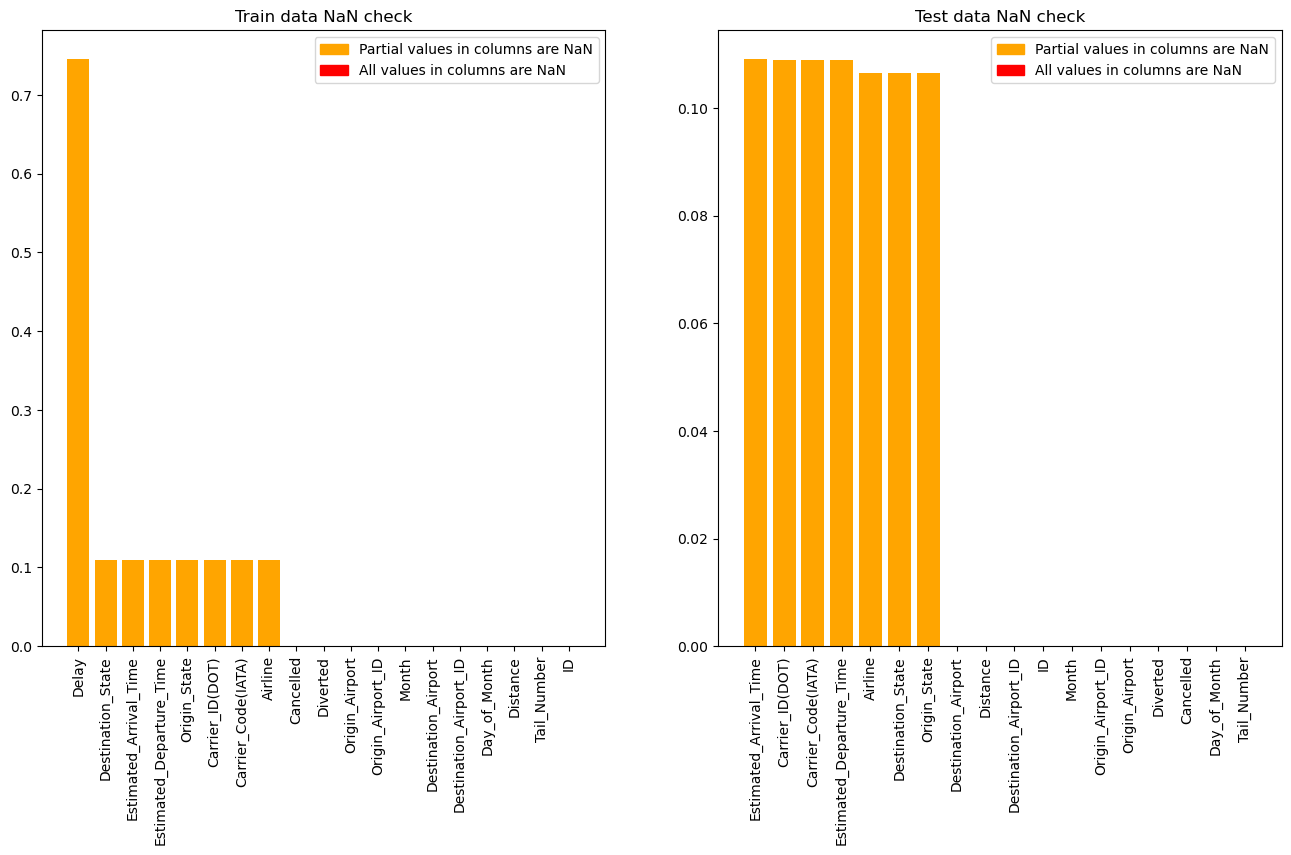

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize = (16,8))
x = np.arange(len(train_row_NaN.index))
plt.subplot(1, 2, 1)
plt.xticks(x, train_row_NaN.index)
plt.xticks(rotation=90)
plt.legend(handles=[mpatches.Patch(color='orange'),
                    mpatches.Patch(color='red')], 
           labels=['Partial values in columns are NaN', 'All values in columns are NaN'])

def color(data):
    if data == 1:
        return 'red'
    else:
        return 'orange'
plt.bar(x, train_row_NaN['결손값_ratio'], color = [color(i) for i in train_row_NaN['결손값_ratio']])
plt.title('Train data NaN check')

test.isnull().sum(axis=0)
test_row_NaN = pd.DataFrame(test.isnull().sum(axis=0), columns = column)
test_row_NaN = test_row_NaN.sort_values(by = '결손값 개수', ascending = False)
test_row_su = test.shape[0]
test_row_NaN['결손값_ratio'] = test_row_NaN['결손값 개수']/test_row_su

plt.subplot(1, 2, 2)
x2 = np.arange(len(test_row_NaN.index))
plt.xticks(x2, test_row_NaN.index)
plt.xticks(rotation=90)
plt.legend(handles=[mpatches.Patch(color='orange'),
                    mpatches.Patch(color='red')], 
           labels=['Partial values in columns are NaN', 'All values in columns are NaN'])
plt.bar(x2, test_row_NaN['결손값_ratio'], color = [color(i) for i in test_row_NaN['결손값_ratio']])
plt.title('Test data NaN check')

print(train_row_NaN)
print(test_row_NaN)
plt.show()

기존 train 데이터로 self training을 진행하여 null이 있는 열을 학습시켜야함.
순서는 null이 적은 값부터 많은 순서대로 학습
Airline > Carrier_ID(DOT) > Carrier_Code(IATA) > Estimated_Departure_Time > Estimated_Arrival_Time > delay

예시로 Airline을 채우는 self_training에 대한 코드

1. Airline - self_training

In [13]:
# 준지도 학습 전 라벨링
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [14]:
train_lb = train.__deepcopy__() #복사
test_lb = test.__deepcopy__() #복사 

label_st = train_lb.drop(columns = ['Airline']) #airline 컬럼 삭제

#airline이 결측치가 아니였던 데이터 / 891080 row x 18col
train_st = train_lb[(train_lb['Airline'].astype(str) != 'nan')].drop(columns = ['Airline']) 

#airline이 결측치였던 데이터/ 108920 row x 18 col
X_nan = train_lb[(train_lb['Airline'].astype(str) == 'nan')].drop(columns = ['Airline']) #108920

#test 데이터에서 airline이 결측치였던 데이터.  106527 row x 17 col
test_nan = test_lb[(test_lb['Airline'].astype(str) == 'None')|(test_lb['Airline'].astype(str) == 'nan')].drop(columns = ['Airline'])

In [15]:
# NULL이 없으면서 라벨링이 필요한 열들 정리
qual_col = ['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Tail_Number']

In [16]:
train_st.isna().sum()

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time     97285
Estimated_Arrival_Time       97144
Cancelled                        0
Diverted                         0
Origin_Airport                   0
Origin_Airport_ID                0
Origin_State                 97345
Destination_Airport              0
Destination_Airport_ID           0
Destination_State            97103
Distance                         0
Carrier_Code(IATA)           97126
Carrier_ID(DOT)              97114
Tail_Number                      0
Delay                       663619
dtype: int64

In [17]:
for i in qual_col:
    le = LabelEncoder()
    le=le.fit(label_st[i])
    for label in np.unique(test[i].dropna()):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    train_lb[i] = le.transform(train_lb[i])
    train_st[i]=le.transform(train_st[i])
    X_nan[i]=le.transform(X_nan[i])
    test_nan[i]=le.transform(test_nan[i])

In [18]:
# Airline self_training
original_col = ['Cancelled','Diverted','Origin_Airport','Origin_Airport_ID', 'Origin_State', 'Destination_Airport', 'Destination_Airport_ID', 'Destination_State', 'Tail_Number', 'Month', 'Day_of_Month','Distance']

X = train_st[original_col]
y = train_lb[(train_lb['Airline'].astype(str) != 'nan')][original_col + ['Airline']]['Airline']

stclf = SelfTrainingClassifier(
    base_estimator = RandomForestClassifier(n_estimators = 100),
    verbose = True)

stclf.fit(X, y)   

SelfTrainingClassifier(base_estimator=RandomForestClassifier(), verbose=True)

In [19]:
# 결과값 삽입

X_nan['Airline_pred'] = stclf.predict(X_nan[original_col])
test_nan['Airline_pred'] = stclf.predict(test_nan[original_col])
train_lb.loc[train_lb['Airline'].astype(str) == 'nan', 'Airline'] = X_nan['Airline_pred']
test_lb.loc[test_lb['Airline'].astype(str) == 'nan', 'Airline'] = test_nan['Airline_pred']

In [20]:
train_lb[train_lb['Airline'].isna()]

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay


In [21]:
test_lb[train_lb['Airline'].isna()]


,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number


In [22]:
train_lb['Airline'].unique()


array(['Southwest Airlines Co.', 'SkyWest Airlines Inc.',
       'American Airlines Inc.', 'United Air Lines Inc.',
       'Republic Airlines', 'ExpressJet Airlines Inc.',
       'Delta Air Lines Inc.', 'Air Wisconsin Airlines Corp',
       'Horizon Air', 'JetBlue Airways', 'Spirit Air Lines',
       'Alaska Airlines Inc.', 'Mesa Airlines Inc.',
       'Frontier Airlines Inc.', 'Trans States Airlines',
       'Endeavor Air Inc.', 'Comair Inc.', 'Capital Cargo International',
       'Envoy Air', 'Hawaiian Airlines Inc.', 'Allegiant Air',
       'Virgin America', 'Peninsula Airways Inc.', 'Compass Airlines',
       'GoJet Airlines, LLC d/b/a United Express',
       'Commutair Aka Champlain Enterprises, Inc.',
       'Empire Airlines Inc.', 'Cape Air'], dtype=object)

In [23]:
test_lb['Airline'].unique()


array(['United Air Lines Inc.', 'Delta Air Lines Inc.',
       'Southwest Airlines Co.', 'JetBlue Airways',
       'SkyWest Airlines Inc.', 'Spirit Air Lines', 'Republic Airlines',
       'Compass Airlines', 'Mesa Airlines Inc.', 'American Airlines Inc.',
       'Alaska Airlines Inc.', 'Envoy Air', 'Hawaiian Airlines Inc.',
       'GoJet Airlines, LLC d/b/a United Express', 'Horizon Air',
       'Allegiant Air', 'Trans States Airlines', 'Comair Inc.',
       'Frontier Airlines Inc.', 'Capital Cargo International',
       'Air Wisconsin Airlines Corp', 'ExpressJet Airlines Inc.',
       'Endeavor Air Inc.', 'Commutair Aka Champlain Enterprises, Inc.',
       'Empire Airlines Inc.', 'Virgin America', 'Peninsula Airways Inc.',
       'Cape Air'], dtype=object)

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

                          결손값 개수  결손값_ratio
Delay                     744999   0.744999
Estimated_Arrival_Time    109040   0.109040
Estimated_Departure_Time  109019   0.109019
Carrier_ID(DOT)           108997   0.108997
Carrier_Code(IATA)        108990   0.108990
Destination_Airport_ID         0   0.000000
Tail_Number                    0   0.000000
Airline                        0   0.000000
Distance                       0   0.000000
Destination_State              0   0.000000
ID                             0   0.000000
Destination_Airport            0   0.000000
Month                          0   0.000000
Origin_Airport_ID              0   0.000000
Origin_Airport                 0   0.000000
Diverted                       0   0.000000
Cancelled                      0   0.000000
Day_of_Month                   0   0.000000
Origin_State                   0   0.000000
                          결손값 개수  결손값_ratio
Estimated_Arrival_Time    109048   0.109048
Carrier_ID(DOT)           109006

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

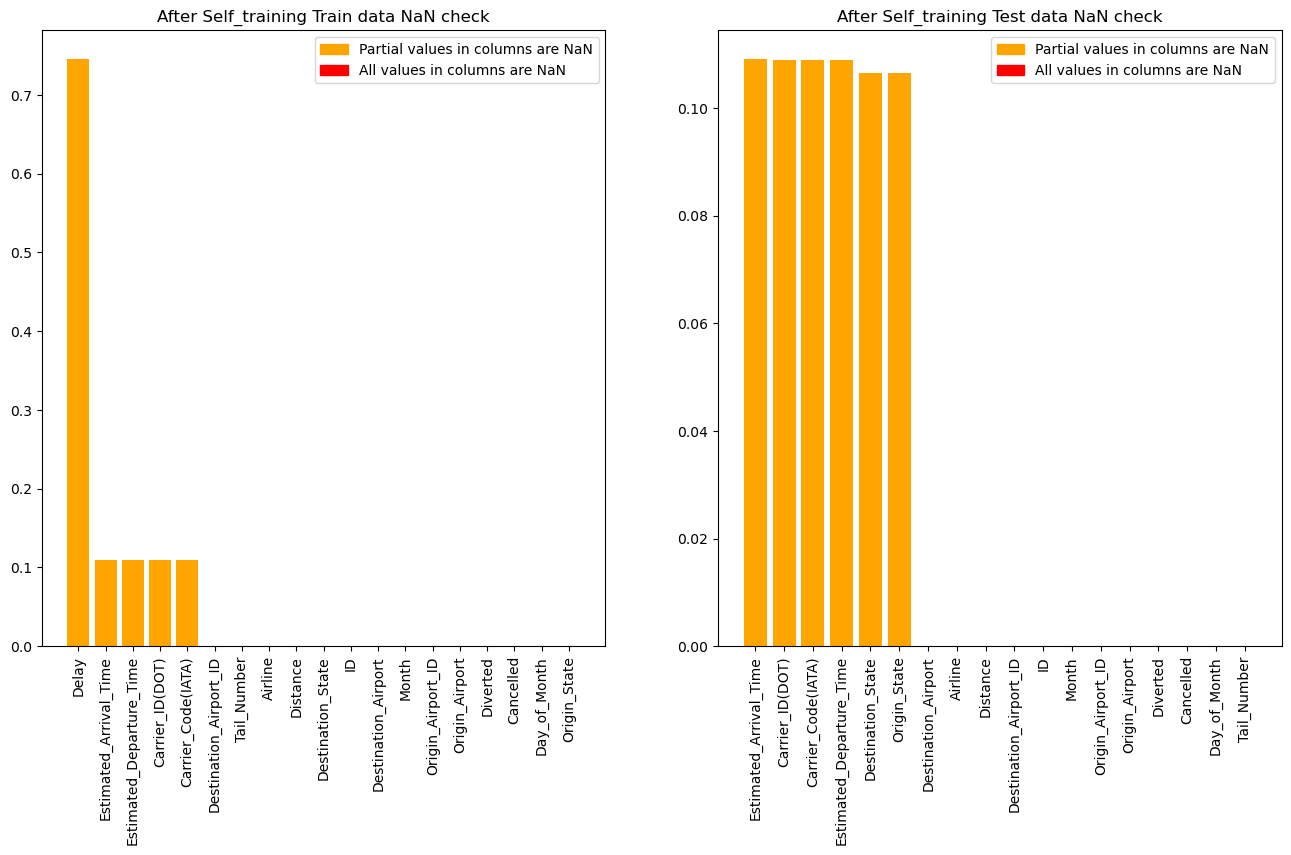

In [24]:
#airline 학습 후 결과 그래프로 
import matplotlib

matplotlib.rcParams['font.family'] = 'NanumBarunGothic'
matplotlib.rcParams['axes.unicode_minus'] = False

column = ['결손값 개수']
axis_1 = pd.DataFrame(data = train.isnull().sum(axis=1), columns = column)
axis_1 = axis_1.sort_values(by = '결손값 개수', ascending = False)

train_lb.isnull().sum(axis=0)
train_row_NaN = pd.DataFrame(train_lb.isnull().sum(axis=0), columns = column)
train_row_NaN = train_row_NaN.sort_values(by = '결손값 개수', ascending = False)
train_row_su = train.shape[0]
train_row_NaN['결손값_ratio'] = train_row_NaN['결손값 개수']/train_row_su

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize = (16,8))
x = np.arange(len(train_row_NaN.index))
plt.subplot(1, 2, 1)
plt.xticks(x, train_row_NaN.index)
plt.xticks(rotation=90)
plt.legend(handles=[mpatches.Patch(color='orange'),
                    mpatches.Patch(color='red')], 
           labels=['Partial values in columns are NaN', 'All values in columns are NaN'])

def color(data):
    if data == 1:
        return 'red'
    else:
        return 'orange'
plt.bar(x, train_row_NaN['결손값_ratio'], color = [color(i) for i in train_row_NaN['결손값_ratio']])
plt.title('After Self_training Train data NaN check')

test_lb.isnull().sum(axis=0)
test_row_NaN = pd.DataFrame(test_lb.isnull().sum(axis=0), columns = column)
test_row_NaN = test_row_NaN.sort_values(by = '결손값 개수', ascending = False)
test_row_su = test.shape[0]
test_row_NaN['결손값_ratio'] = test_row_NaN['결손값 개수']/test_row_su

plt.subplot(1, 2, 2)
x2 = np.arange(len(test_row_NaN.index))
plt.xticks(x2, test_row_NaN.index)
plt.xticks(rotation=90)
plt.legend(handles=[mpatches.Patch(color='orange'),
                    mpatches.Patch(color='red')], 
           labels=['Partial values in columns are NaN', 'All values in columns are NaN'])
plt.bar(x2, test_row_NaN['결손값_ratio'], color = [color(i) for i in test_row_NaN['결손값_ratio']])
plt.title('After Self_training Test data NaN check')

print(train_row_NaN)
print(test_row_NaN)
plt.show()

In [25]:
#최종 ---> 각자 다 다돌린다고 치고. 함수로 지정해서 리스트 / estimate_departure_time, arrival_time은 채울 수 있으니까 .. 
#['Airline' > 'Carrier_ID(DOT)''> 'Carrier_Code(IATA)' > 'Estimated_Departure_Time' > 'Estimated_Arrival_Time > delay']

In [26]:
train_lb.isna().sum()

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time    109019
Estimated_Arrival_Time      109040
Cancelled                        0
Diverted                         0
Origin_Airport                   0
Origin_Airport_ID                0
Origin_State                     0
Destination_Airport              0
Destination_Airport_ID           0
Destination_State                0
Distance                         0
Airline                          0
Carrier_Code(IATA)          108990
Carrier_ID(DOT)             108997
Tail_Number                      0
Delay                       744999
dtype: int64

In [27]:
train.isna().sum()

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time    109019
Estimated_Arrival_Time      109040
Cancelled                        0
Diverted                         0
Origin_Airport                   0
Origin_Airport_ID                0
Origin_State                109015
Destination_Airport              0
Destination_Airport_ID           0
Destination_State           109079
Distance                         0
Airline                     108920
Carrier_Code(IATA)          108990
Carrier_ID(DOT)             108997
Tail_Number                      0
Delay                       744999
dtype: int64

In [ ]:
#origin state랑 destination state 데이터  거리 기준으로 채워 넣고 이걸 다시 돌리면?
#논리연산자 부정연산자

Carrier_ID(DOT)

In [32]:
train.columns

Index(['ID', 'Month', 'Day_of_Month', 'Estimated_Departure_Time',
       'Estimated_Arrival_Time', 'Cancelled', 'Diverted', 'Origin_Airport',
       'Origin_Airport_ID', 'Origin_State', 'Destination_Airport',
       'Destination_Airport_ID', 'Destination_State', 'Distance', 'Airline',
       'Carrier_Code(IATA)', 'Carrier_ID(DOT)', 'Tail_Number', 'Delay'],
      dtype='object')

In [36]:
# 준지도 학습 전 라벨링
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
 
# train_lb = train.__deepcopy__()
# test_lb = test.__deepcopy__()

label_st = train_lb.drop(columns = ['Carrier_ID(DOT)'])
train_st = train_lb[(train_lb['Carrier_ID(DOT)'].astype(str) != 'nan')].drop(columns = ['Carrier_ID(DOT)'])
X_nan = train_lb[(train_lb['Carrier_ID(DOT)'].astype(str) == 'nan')].drop(columns = ['Carrier_ID(DOT)'])
test_nan = test_lb[(test_lb['Carrier_ID(DOT)'].astype(str) == 'None')|(test_lb['Carrier_ID(DOT)'].astype(str) == 'nan')].drop(columns = ['Carrier_ID(DOT)'])

In [38]:
# NULL이 없으면서 라벨링이 필요한 열들 정리
qual_col = ['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Tail_Number']

for i in qual_col:
    le = LabelEncoder()
    le=le.fit(label_st[i])
    for label in np.unique(test[i].dropna()):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    train_lb[i] = le.transform(train_lb[i])
    train_st[i]=le.transform(train_st[i])
    X_nan[i]=le.transform(X_nan[i])
    test_nan[i]=le.transform(test_nan[i])

In [40]:
# Carrier_ID(DOT) self_training
original_col = ['Cancelled','Diverted','Origin_Airport','Origin_Airport_ID', 'Origin_State', 'Destination_Airport', 'Destination_Airport_ID', 'Destination_State', 'Tail_Number', 'Month', 'Day_of_Month','Distance']

X = train_st[original_col]
y = train_lb[(train_lb['Carrier_ID(DOT)'].astype(str) != 'nan')][original_col + ['Carrier_ID(DOT)']]['Carrier_ID(DOT)']

stclf = SelfTrainingClassifier(
    base_estimator = RandomForestClassifier(n_estimators = 100),
    verbose = True)

stclf.fit(X, y)    

SelfTrainingClassifier(base_estimator=RandomForestClassifier(), verbose=True)

In [41]:
# 결과값 삽입

X_nan['Carrier_ID(DOT)_pred'] = stclf.predict(X_nan[original_col])
test_nan['Carrier_ID(DOT)_pred'] = stclf.predict(test_nan[original_col])
train_lb.loc[train_lb['Carrier_ID(DOT)'].astype(str) == 'nan', 'Carrier_ID(DOT)'] = X_nan['Carrier_ID(DOT)_pred']
test_lb.loc[test_lb['Carrier_ID(DOT)'].astype(str) == 'nan', 'Carrier_ID(DOT)'] = test_nan['Carrier_ID(DOT)_pred']

In [42]:
train_lb[train_lb['Carrier_ID(DOT)'].isna()]

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay


In [43]:
test_lb[train_lb['Carrier_ID(DOT)'].isna()]

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number


함수로 정의 

In [61]:
# 라벨링 함수 정의
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
 
train_lb = train.__deepcopy__()
test_lb = test.__deepcopy__()

def labeling(train_lb, column):
    label_st = train_lb.drop(columns = [column])
    train_st = train_lb[(train_lb[column].astype(str) != 'nan')].drop(columns = [column])
    X_nan = train_lb[(train_lb[column].astype(str) == 'nan')].drop(columns = [column])
    test_nan = test_lb[(test_lb[column].astype(str) == 'None')|(test_lb[column].astype(str) == 'nan')].drop(columns = [column])
    
    # NULL이 없으면서 라벨링이 필요한 열들 정리
    qual_col = ['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Tail_Number']
    for i in qual_col:
        le = LabelEncoder()
        le=le.fit(label_st[i])
        for label in np.unique(test[i].dropna()):
            if label not in le.classes_: 
                le.classes_ = np.append(le.classes_, label)
        train_lb[i] = le.transform(train_lb[i])
        train_st[i]=le.transform(train_st[i])
        X_nan[i]=le.transform(X_nan[i])
        test_nan[i]=le.transform(test_nan[i])
    return train_lb, train_st

In [62]:
#준지도학습 
def training(train_lb, column):
    original_col = ['Cancelled','Diverted','Origin_Airport','Origin_Airport_ID', 'Origin_State', 'Destination_Airport', 'Destination_Airport_ID', 'Destination_State', 'Tail_Number', 'Month', 'Day_of_Month','Distance']

    X = train_st[original_col]
    y = train_lb[(train_lb[column].astype(str) != 'nan')][original_col + [column]][column]

    stclf = SelfTrainingClassifier(
        base_estimator = RandomForestClassifier(n_estimators = 100),
        verbose = True)
    
    #학습
    stclf.fit(X, y)    
    
    #결과값 삽입
    X_nan[f'{column}_pred'] = stclf.predict(X_nan[original_col])
    test_nan[f'{column}_pred'] = stclf.predict(test_nan[original_col])
    train_lb.loc[train_lb[column].astype(str) == 'nan', column] = X_nan[f'{column}_pred']
    test_lb.loc[test_lb[column].astype(str) == 'nan', column] = test_nan[f'{column}_pred']
    return  train_lb, test_lb

self_training 함수 정의

In [59]:
# 라벨링 함수 정의
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
 
train_lb = train.__deepcopy__()
test_lb = test.__deepcopy__()

def self_training(train_lb, column):
    
    #지도학습전 라벨링 
    def labeling(train_lb, column):
        label_st = train_lb.drop(columns = [column])
        train_st = train_lb[(train_lb[column].astype(str) != 'nan')].drop(columns = [column])
        X_nan = train_lb[(train_lb[column].astype(str) == 'nan')].drop(columns = [column])
        test_nan = test_lb[(test_lb[column].astype(str) == 'None')|(test_lb[column].astype(str) == 'nan')].drop(columns = [column])

        # NULL이 없으면서 라벨링이 필요한 열들 정리
        qual_col = ['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Tail_Number']
        for i in qual_col:
            le = LabelEncoder()
            le=le.fit(label_st[i])
            for label in np.unique(test[i].dropna()):
                if label not in le.classes_: 
                    le.classes_ = np.append(le.classes_, label)
            train_lb[i] = le.transform(train_lb[i])
            train_st[i]=le.transform(train_st[i])
            X_nan[i]=le.transform(X_nan[i])
            test_nan[i]=le.transform(test_nan[i])
        return train_lb, train_st


    #준지도학습 
    def training(train_lb, column):
        original_col = ['Cancelled','Diverted','Origin_Airport','Origin_Airport_ID', 'Origin_State', 'Destination_Airport', 'Destination_Airport_ID', 'Destination_State', 'Tail_Number', 'Month', 'Day_of_Month','Distance']

        X = train_st[original_col]
        y = train_lb[(train_lb[column].astype(str) != 'nan')][original_col + [column]][column]

        stclf = SelfTrainingClassifier(
            base_estimator = RandomForestClassifier(n_estimators = 100),
            verbose = True)

        #학습
        stclf.fit(X, y)    

        #결과값 삽입
        X_nan[f'{column}_pred'] = stclf.predict(X_nan[original_col])
        test_nan[f'{column}_pred'] = stclf.predict(test_nan[original_col])
        train_lb.loc[train_lb[column].astype(str) == 'nan', column] = X_nan[f'{column}_pred']
        test_lb.loc[test_lb[column].astype(str) == 'nan', column] = test_nan[f'{column}_pred']
        return train_lb, test_lb
    
    return  train_lb, test_lb

In [ ]:
#최종 ---> 각자 다 다돌린다고 치고. 함수로 지정해서 리스트 / estimate_departure_time, arrival_time은 채울 수 있으니까 .. 
#['Airline' > 'Carrier_ID(DOT)''> 'Carrier_Code(IATA)' > 'Estimated_Departure_Time' > 'Estimated_Arrival_Time > delay']

In [55]:
nan_list = ['Airline', 'Carrier_ID(DOT)','Carrier_Code(IATA)','Delay']

Airline 준지도학습

In [67]:
# 준지도 학습 전 라벨링
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
 
train_lb = train.__deepcopy__()
test_lb = test.__deepcopy__()

label_st = train_lb.drop(columns = ['Airline'])
train_st = train_lb[(train_lb['Airline'].astype(str) != 'nan')].drop(columns = ['Airline'])
X_nan = train_lb[(train_lb['Airline'].astype(str) == 'nan')].drop(columns = ['Airline'])
test_nan = test_lb[(test_lb['Airline'].astype(str) == 'None')|(test_lb['Airline'].astype(str) == 'nan')].drop(columns = ['Airline'])

# NULL이 없으면서 라벨링이 필요한 열들 정리
qual_col = ['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Tail_Number']

for i in qual_col:
    le = LabelEncoder()
    le=le.fit(label_st[i])
    for label in np.unique(test[i].dropna()):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    train_lb[i] = le.transform(train_lb[i])
    train_st[i]=le.transform(train_st[i])
    X_nan[i]=le.transform(X_nan[i])
    test_nan[i]=le.transform(test_nan[i])

In [68]:
# Airline self_training
original_col = ['Cancelled','Diverted','Origin_Airport','Origin_Airport_ID', 'Origin_State', 'Destination_Airport', 'Destination_Airport_ID', 'Destination_State', 'Tail_Number', 'Month', 'Day_of_Month','Distance']

X = train_st[original_col]
y = train_lb[(train_lb['Airline'].astype(str) != 'nan')][original_col + ['Airline']]['Airline']

stclf = SelfTrainingClassifier(
    base_estimator = RandomForestClassifier(n_estimators = 100),
    verbose = True)

stclf.fit(X, y)    

SelfTrainingClassifier(base_estimator=RandomForestClassifier(), verbose=True)

In [70]:
# 결과값 삽입

X_nan['Airline_pred'] = stclf.predict(X_nan[original_col])
test_nan['Airline_pred'] = stclf.predict(test_nan[original_col])
train_lb.loc[train_lb['Airline'].astype(str) == 'nan', 'Airline'] = X_nan['Airline_pred']
test_lb.loc[test_lb['Airline'].astype(str) == 'nan', 'Airline'] = test_nan['Airline_pred']

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

                          결손값 개수  결손값_ratio
Delay                     744999   0.744999
Estimated_Arrival_Time    109040   0.109040
Estimated_Departure_Time  109019   0.109019
Carrier_ID(DOT)           108997   0.108997
Carrier_Code(IATA)        108990   0.108990
Destination_Airport_ID         0   0.000000
Tail_Number                    0   0.000000
Airline                        0   0.000000
Distance                       0   0.000000
Destination_State              0   0.000000
ID                             0   0.000000
Destination_Airport            0   0.000000
Month                          0   0.000000
Origin_Airport_ID              0   0.000000
Origin_Airport                 0   0.000000
Diverted                       0   0.000000
Cancelled                      0   0.000000
Day_of_Month                   0   0.000000
Origin_State                   0   0.000000
                          결손값 개수  결손값_ratio
Estimated_Arrival_Time    109048   0.109048
Carrier_ID(DOT)           109006

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

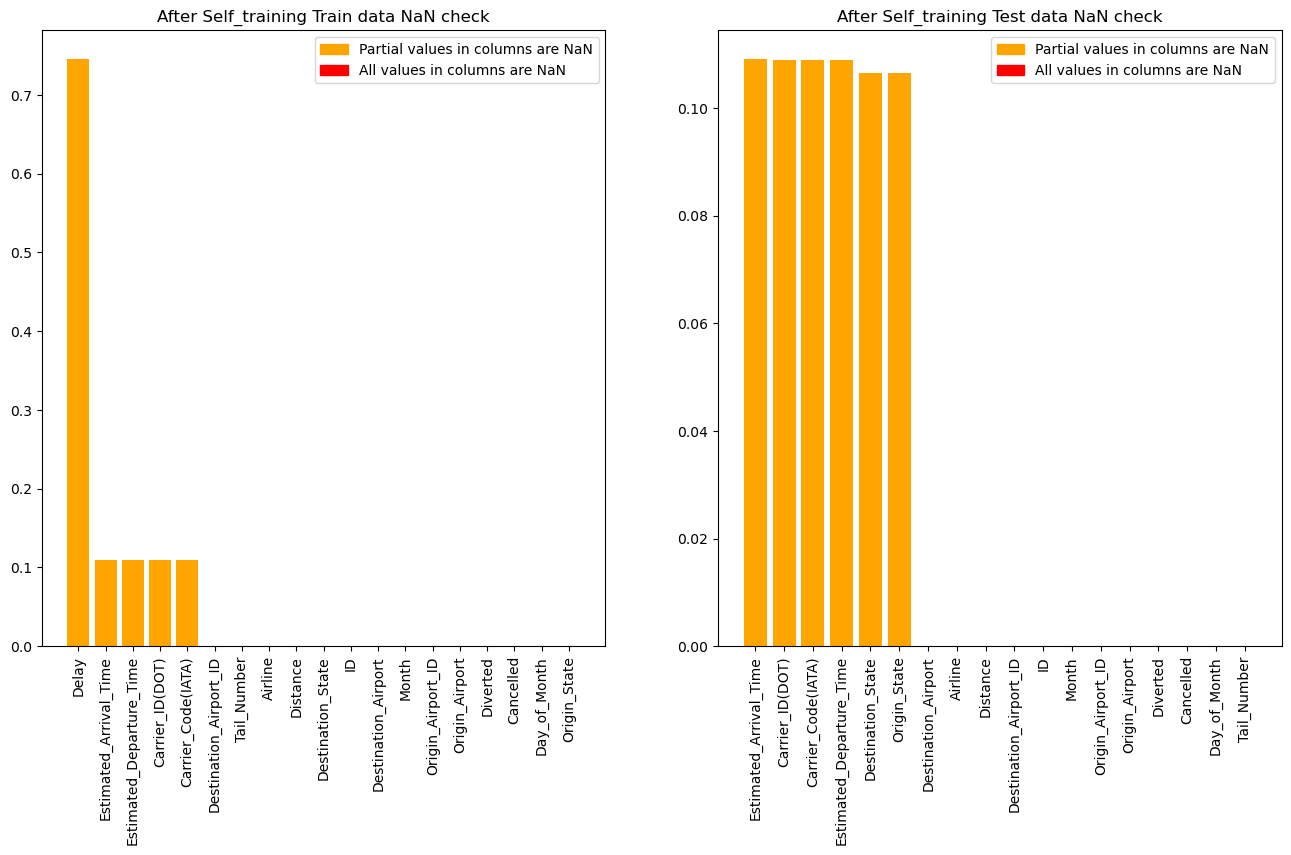

In [71]:
column = ['결손값 개수']
axis_1 = pd.DataFrame(data = train.isnull().sum(axis=1), columns = column)
axis_1 = axis_1.sort_values(by = '결손값 개수', ascending = False)

train_lb.isnull().sum(axis=0)
train_row_NaN = pd.DataFrame(train_lb.isnull().sum(axis=0), columns = column)
train_row_NaN = train_row_NaN.sort_values(by = '결손값 개수', ascending = False)
train_row_su = train.shape[0]
train_row_NaN['결손값_ratio'] = train_row_NaN['결손값 개수']/train_row_su

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize = (16,8))
x = np.arange(len(train_row_NaN.index))
plt.subplot(1, 2, 1)
plt.xticks(x, train_row_NaN.index)
plt.xticks(rotation=90)
plt.legend(handles=[mpatches.Patch(color='orange'),
                    mpatches.Patch(color='red')], 
           labels=['Partial values in columns are NaN', 'All values in columns are NaN'])

def color(data):
    if data == 1:
        return 'red'
    else:
        return 'orange'
plt.bar(x, train_row_NaN['결손값_ratio'], color = [color(i) for i in train_row_NaN['결손값_ratio']])
plt.title('After Self_training Train data NaN check')

test_lb.isnull().sum(axis=0)
test_row_NaN = pd.DataFrame(test_lb.isnull().sum(axis=0), columns = column)
test_row_NaN = test_row_NaN.sort_values(by = '결손값 개수', ascending = False)
test_row_su = test.shape[0]
test_row_NaN['결손값_ratio'] = test_row_NaN['결손값 개수']/test_row_su

plt.subplot(1, 2, 2)
x2 = np.arange(len(test_row_NaN.index))
plt.xticks(x2, test_row_NaN.index)
plt.xticks(rotation=90)
plt.legend(handles=[mpatches.Patch(color='orange'),
                    mpatches.Patch(color='red')], 
           labels=['Partial values in columns are NaN', 'All values in columns are NaN'])
plt.bar(x2, test_row_NaN['결손값_ratio'], color = [color(i) for i in test_row_NaN['결손값_ratio']])
plt.title('After Self_training Test data NaN check')

print(train_row_NaN)
print(test_row_NaN)
plt.show()

In [75]:
train_lb[(train_lb['Carrier_ID(DOT)'].astype(str) != 'nan')]

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,TRAIN_000000,4,15,NaN,NaN,0,0,252,13851,34,159,12191,42,419.0,Southwest Airlines Co.,WN,19393.0,4319,NaN
1,TRAIN_000001,8,15,740.0,1024.0,0,0,256,13930,11,331,14869,45,1250.0,SkyWest Airlines Inc.,UA,20304.0,310,NaN
2,TRAIN_000002,9,6,1610.0,1805.0,0,0,74,11057,31,204,12953,30,544.0,American Airlines Inc.,AA,19805.0,140,NaN
4,TRAIN_000004,1,11,900.0,1019.0,0,0,322,14771,4,7,10157,4,250.0,SkyWest Airlines Inc.,UA,20304.0,556,NaN
5,TRAIN_000005,4,13,1545.0,NaN,0,0,119,11618,52,93,11278,47,199.0,Republic Airlines,UA,20452.0,3435,Not_Delayed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,TRAIN_999994,6,26,NaN,1800.0,0,0,90,11259,52,322,14771,4,1476.0,SkyWest Airlines Inc.,AS,20304.0,640,NaN
999995,TRAIN_999995,9,18,936.0,1243.0,0,0,256,13930,52,270,14100,52,678.0,United Air Lines Inc.,UA,19977.0,2477,NaN
999997,TRAIN_999997,6,28,800.0,1340.0,0,0,248,13796,52,159,12191,42,1642.0,Southwest Airlines Co.,WN,19393.0,994,NaN
999998,TRAIN_999998,9,27,1613.0,1824.0,0,0,45,10693,41,22,10397,52,214.0,Delta Air Lines Inc.,DL,19790.0,6207,NaN


'Carrier_ID(DOT)' 

In [77]:
# 준지도 학습 전 라벨링
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

label_st = train_lb.drop(columns = ['Carrier_ID(DOT)'])
train_st = train_lb[(train_lb['Carrier_ID(DOT)'].astype(str) != 'nan')].drop(columns = ['Carrier_ID(DOT)'])
X_nan = train_lb[(train_lb['Carrier_ID(DOT)'].astype(str) == 'nan')].drop(columns = ['Carrier_ID(DOT)'])
test_nan = test_lb[(test_lb['Carrier_ID(DOT)'].astype(str) == 'None')|(test_lb['Carrier_ID(DOT)'].astype(str) == 'nan')].drop(columns = ['Carrier_ID(DOT)'])

# NULL이 없으면서 라벨링이 필요한 열들 정리
# qual_col = ['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Tail_Number']

# for i in qual_col:
#     le = LabelEncoder()
#     le=le.fit(label_st[i])
#     for label in np.unique(test[i].dropna()):
#         if label not in le.classes_: 
#             le.classes_ = np.append(le.classes_, label)
#     train_lb[i] = le.transform(train_lb[i])
#     train_st[i]=le.transform(train_st[i])
#     X_nan[i]=le.transform(X_nan[i])
#     test_nan[i]=le.transform(test_nan[i])

In [78]:
# Airline self_training
original_col = ['Cancelled','Diverted','Origin_Airport','Origin_Airport_ID', 'Origin_State', 'Destination_Airport', 'Destination_Airport_ID', 'Destination_State', 'Tail_Number', 'Month', 'Day_of_Month','Distance']

X = train_st[original_col]
y = train_lb[(train_lb['Carrier_ID(DOT)'].astype(str) != 'nan')][original_col + ['Carrier_ID(DOT)']]['Carrier_ID(DOT)']

stclf = SelfTrainingClassifier(
    base_estimator = RandomForestClassifier(n_estimators = 100),
    verbose = True)

stclf.fit(X, y)   

SelfTrainingClassifier(base_estimator=RandomForestClassifier(), verbose=True)

In [82]:
test_nan

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Tail_Number
0,TEST_000000,12,16,1156.0,NaN,0,0,IAH,12266,Texas,SAT,14683,Texas,191.0,United Air Lines Inc.,UA,N79402
7,TEST_000007,2,4,1030.0,1245.0,0,0,BNA,10693,Tennessee,CMH,11066,Ohio,337.0,Southwest Airlines Co.,WN,N8312C
19,TEST_000019,10,8,614.0,759.0,0,0,CMH,11066,Ohio,LGA,12953,New York,479.0,Republic Airlines,DL,N216JQ
21,TEST_000021,1,31,NaN,816.0,0,0,ONT,13891,California,PHX,14107,Arizona,325.0,American Airlines Inc.,AA,N193UW
22,TEST_000022,1,20,1025.0,1138.0,0,0,ATL,10397,Georgia,TRI,15323,Tennessee,227.0,SkyWest Airlines Inc.,DL,N446SW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999943,TEST_999943,10,21,730.0,935.0,0,0,CLE,11042,Ohio,LAX,12892,California,2052.0,Spirit Air Lines,NaN,N63820
999946,TEST_999946,10,1,1930.0,2035.0,0,0,FLL,11697,Florida,TPA,15304,NaN,197.0,Southwest Airlines Co.,WN,N7825A
999978,TEST_999978,8,22,1715.0,125.0,0,0,SFO,14771,California,EWR,11618,New Jersey,2565.0,United Air Lines Inc.,NaN,N2331U
999988,TEST_999988,7,4,2204.0,2313.0,0,0,BWI,10821,Maryland,ORD,13930,Illinois,622.0,Spirit Air Lines,NaN,N608NK


In [81]:
# 결과값 삽입

X_nan['Carrier_ID(DOT)_pred'] = stclf.predict(X_nan[original_col])
test_nan['Carrier_ID(DOT)_pred'] = stclf.predict(test_nan[original_col])
# train_lb.loc[train_lb['Carrier_ID(DOT)'].astype(str) == 'nan', 'Carrier_ID(DOT)'] = X_nan['Carrier_ID(DOT)_pred']
# test_lb.loc[test_lb['Carrier_ID(DOT)'].astype(str) == 'nan', 'Carrier_ID(DOT)'] = test_nan['Carrier_ID(DOT)_pred']

ValueError: could not convert string to float: 'IAH'

'Carrier_Code(IATA)'

In [ ]:
# 준지도 학습 전 라벨링
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

label_st = train_lb.drop(columns = ['Carrier_ID(IATA)'])
train_st = train_lb[(train_lb['Carrier_ID(IATA)'].astype(str) != 'nan')].drop(columns = ['Carrier_ID(IATA)'])
X_nan = train_lb[(train_lb['Carrier_ID(IATA)'].astype(str) == 'nan')].drop(columns = ['Carrier_ID(IATA)'])
test_nan = test_lb[(test_lb['Carrier_ID(IATA)'].astype(str) == 'None')|(test_lb['Carrier_ID(IATA)'].astype(str) == 'nan')].drop(columns = ['Carrier_ID(IATA)'])

# NULL이 없으면서 라벨링이 필요한 열들 정리
qual_col = ['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Tail_Number']

for i in qual_col:
    le = LabelEncoder()
    le=le.fit(label_st[i])
    for label in np.unique(test[i].dropna()):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    train_lb[i] = le.transform(train_lb[i])
    train_st[i]=le.transform(train_st[i])
    X_nan[i]=le.transform(X_nan[i])
    test_nan[i]=le.transform(test_nan[i])

In [ ]:
#Carrier_ID(IATA) self-training
original_col = ['Cancelled','Diverted','Origin_Airport','Origin_Airport_ID', 'Origin_State', 'Destination_Airport', 'Destination_Airport_ID', 'Destination_State', 'Tail_Number', 'Month', 'Day_of_Month','Distance']

X = train_st[original_col]
y = train_lb[(train_lb['Carrier_ID(IATA)'].astype(str) != 'nan')][original_col + ['Carrier_ID(IATA)']]['Carrier_ID(IATA)']

stclf = SelfTrainingClassifier(
    base_estimator = RandomForestClassifier(n_estimators = 100),
    verbose = True)

stclf.fit(X, y)   

In [ ]:
# 결과값 삽입

X_nan['Carrier_ID(IATA)_pred'] = stclf.predict(X_nan[original_col])
test_nan['Carrier_ID(IATA)_pred'] = stclf.predict(test_nan[original_col])
train_lb.loc[train_lb['Carrier_ID(IATA)'].astype(str) == 'nan', 'Carrier_ID(IATA)'] = X_nan['Carrier_ID(IATA)_pred']
test_lb.loc[test_lb['Carrier_ID(IATA)'].astype(str) == 'nan', 'Carrier_ID(IATA)'] = test_nan['Carrier_ID(IATA)_pred']

'Delay'

In [ ]:
# 준지도 학습 전 라벨링
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

label_st = train_lb.drop(columns = ['Delay'])
train_st = train_lb[(train_lb['Delay'].astype(str) != 'nan')].drop(columns = ['Delay'])
X_nan = train_lb[(train_lb['Delay'].astype(str) == 'nan')].drop(columns = ['Delay'])
test_nan = test_lb[(test_lb['Delay'].astype(str) == 'None')|(test_lb['Delay'].astype(str) == 'nan')].drop(columns = ['Delay'])

# NULL이 없으면서 라벨링이 필요한 열들 정리
qual_col = ['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Tail_Number']

for i in qual_col:
    le = LabelEncoder()
    le=le.fit(label_st[i])
    for label in np.unique(test[i].dropna()):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    train_lb[i] = le.transform(train_lb[i])
    train_st[i]=le.transform(train_st[i])
    X_nan[i]=le.transform(X_nan[i])
    test_nan[i]=le.transform(test_nan[i])

In [ ]:
#Delay self-training
original_col = ['Cancelled','Diverted','Origin_Airport','Origin_Airport_ID', 'Origin_State', 'Destination_Airport', 'Destination_Airport_ID', 'Destination_State', 'Tail_Number', 'Month', 'Day_of_Month','Distance']

X = train_st[original_col]
y = train_lb[(train_lb['Delay'].astype(str) != 'nan')][original_col + ['Delay']]['Delay']

stclf = SelfTrainingClassifier(
    base_estimator = RandomForestClassifier(n_estimators = 100),
    verbose = True)

stclf.fit(X, y)  

In [ ]:
# 결과값 삽입

X_nan['Delay_pred'] = stclf.predict(X_nan[original_col])
test_nan['Delay_pred'] = stclf.predict(test_nan[original_col])
train_lb.loc[train_lb['Delay'].astype(str) == 'nan', 'Delay'] = X_nan['Delay_pred']
test_lb.loc[test_lb['Delay'].astype(str) == 'nan', 'Delay'] = test_nan['Delay_pred']

In [1]:
train.nunque()

NameError: name 'train' is not defined